In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kurtosis, skew, entropy

In [2]:
## Loading Data ##

# response
response_df = pd.read_json('./response_trainingset.php')
response_df.set_index('id',inplace=True)
# profile
profile_df = pd.read_json('./profile_trainingset.php')
profile_df.set_index('id',inplace=True)

# call detail record
cdr_df = pd.read_json('./cdr_trainingset.php')

# payment
payment_df = pd.read_json('./payment_trainingset.php')
order_col = ['callingnum','status','timestamp','spending','topup','balance']
payment_df = payment_df[order_col]
payment_df = payment_df.sort_values(['callingnum','timestamp'],ascending=[True,True])

In [6]:
# payment : spending 
sum_ = payment_df.groupby(['callingnum'])['spending'].sum()
count_ = payment_df.groupby(['callingnum'])['spending'].count()
mean_ = sum_/count_
std_ = payment_df.groupby(['callingnum'])['spending'].std()
coefvar_ = std_/mean_
skewness_ = payment_df.groupby(['callingnum'])['spending'].apply(lambda x: skew(x[~np.isnan(x)]))

spending_concat = pd.concat([sum_, count_, mean_, std_, coefvar_, skewness_],axis=1)
spending_concat.columns = ['spending_sum','spending_count','spending_mean','spending_std','spending_coefvar','spending_skewness']


# payment : topup
sum_ = payment_df.groupby(['callingnum'])['topup'].sum()
count_ = payment_df.groupby(['callingnum'])['topup'].count()
mean_ = sum_/count_
std_ = payment_df.groupby(['callingnum'])['topup'].std()
coefvar_ = std_/mean_
skewness_ = payment_df.groupby(['callingnum'])['topup'].apply(lambda x: skew(x[~np.isnan(x)]))

topup_concat = pd.concat([sum_, count_, mean_, std_, coefvar_, skewness_],axis=1)
topup_concat.columns = ['topup_sum','topup_count','topup_mean','topup_std','topup_coefvar','topup_skewness']


payment_concat = pd.concat([spending_concat,topup_concat],axis=1).reset_index()
payment_concat.head(5)

,callingnum,spending_sum,spending_count,spending_mean,spending_std,spending_coefvar,spending_skewness,topup_sum,topup_count,topup_mean,topup_std,topup_coefvar,topup_skewness
0,611011514,1741.0,885,1.967232,3.333304,1.694414,5.519713,1789.0,18,99.388889,35.380518,0.355981,-0.289365
1,611023937,4212.0,996,4.228916,5.330090,1.260392,2.951966,4222.0,24,175.916667,43.849463,0.249263,0.036708
2,611024651,4030.0,1222,3.297872,5.022274,1.522883,3.868665,4064.0,21,193.523810,60.491007,0.312577,0.059429
3,611037056,3466.0,1553,2.231809,10.708730,4.798228,13.852864,3691.0,13,283.923077,106.822642,0.376238,0.302182
4,611075786,3437.0,879,3.910125,11.389056,2.912709,6.240904,3612.0,18,200.666667,77.000382,0.383723,-0.127595


In [7]:
# cdr : calling_duration

sum_ = cdr_df.groupby(['callingnum'])['duration'].sum()
count_ = cdr_df.groupby(['callingnum'])['duration'].count()
mean_ = sum_/count_
std_ = cdr_df.groupby(['callingnum'])['duration'].std()
coefvar_ = std_/mean_
skewness_  = cdr_df.groupby(['callingnum'])['duration'].apply(lambda x: skew(x[~np.isnan(x)]))

calling_concat = pd.concat([sum_, count_, mean_, std_, coefvar_, skewness_],axis=1,join='outer')
calling_concat.columns = ['calling_dur_sum','calling_dur_count','calling_dur_mean','calling_dur_std','calling_dur_coefvar','calling_dur_skewness']


calling_enpropy_location = cdr_df.groupby(['callingnum','location'])['duration'].count().reset_index()
calling_enpropy_location = calling_enpropy_location.groupby(['callingnum'])['duration'].apply(lambda x: entropy(x))

calling_df = pd.concat([calling_concat,calling_enpropy_location],axis=1).reset_index()
calling_df = calling_df.rename(columns={'duration':'calling_enp_loc'})

calling_df.head(5)

,callingnum,calling_dur_sum,calling_dur_count,calling_dur_mean,calling_dur_std,calling_dur_coefvar,calling_dur_skewness,calling_enp_loc
0,611011514,1001.1652,885,1.131260,3.440300,3.041122,5.317004,3.108765
1,611023937,3624.3609,996,3.638917,5.387919,1.480638,2.890552,3.133634
2,611024651,3183.6296,1222,2.605262,5.112124,1.962231,3.733558,3.086196
3,611037056,1970.5791,1553,1.268885,10.757992,8.478300,13.779748,3.129912
4,611075786,2690.1893,879,3.060511,11.478879,3.750641,6.176931,3.531176


In [8]:
res_pro_df = pd.concat([profile_df,response_df],axis=1)
res_pro_df.drop(['paytype'], axis=1,inplace=True)
res_pro_pay_df = pd.merge(left=res_pro_df, right=payment_concat, how='left',left_on='phonenum', right_on='callingnum')
res_pro_pay_cdr_df = pd.merge(left=res_pro_pay_df, right=calling_df, how='left',left_on='phonenum', right_on='callingnum')

print(res_pro_pay_cdr_df.head(5))


   birthdate gender   phonenum  province  status  callingnum_x  spending_sum  \
0   19900425      F  817552981        11       0     817552981        1928.0   
1   19850813      M  617216883        18       1     617216883        1931.0   
2   19750620      F  617541020        72       0     617541020        2672.0   
3   19860805      F  813133042        20       0     813133042        3814.0   
4   19780528      F  615231774        62       0     615231774        1361.0   

   spending_count  spending_mean  spending_std       ...         \
0            1260       1.530159      3.393899       ...          
1             871       2.216992      7.509686       ...          
2            1365       1.957509      2.224816       ...          
3            1162       3.282272      2.752716       ...          
4            1197       1.137009      2.672092       ...          

   topup_coefvar  topup_skewness  callingnum_y  calling_dur_sum  \
0       0.468613       -0.238016     817552981   

In [9]:
# train_test_split:

y = res_pro_pay_cdr_df['status']
X = res_pro_pay_cdr_df.drop(['status'],axis=1)

X_train,X_test,y_train,y_test,indices_train,indices_test = train_test_split(X,y,res_pro_pay_cdr_df.index,test_size=0.3)

# check 
X_train.head(5)

,birthdate,gender,phonenum,province,callingnum_x,spending_sum,spending_count,spending_mean,spending_std,spending_coefvar,...,topup_coefvar,topup_skewness,callingnum_y,calling_dur_sum,calling_dur_count,calling_dur_mean,calling_dur_std,calling_dur_coefvar,calling_dur_skewness,calling_enp_loc
423,19850915,M,611724429,15,611724429,3415.0,1393,2.451543,1.359032,0.554358,...,0.150460,-0.071442,611724429,2695.0033,1393,1.934676,1.330080,0.687495,1.355269,2.828958
935,19800702,M,818211989,36,818211989,2073.0,748,2.771390,1.548808,0.558856,...,0.128834,0.131702,818211989,1695.2824,748,2.266420,1.514268,0.668132,1.445936,3.259265
779,19880721,M,611754337,15,611754337,3365.0,1076,3.127323,1.159614,0.370801,...,0.092631,-0.451544,611754337,2851.7280,1076,2.650305,1.112727,0.419849,0.693294,2.934985
858,19580925,F,613439831,71,613439831,3664.0,747,4.904953,2.621383,0.534436,...,0.128710,0.007583,613439831,3286.6630,747,4.399817,2.608281,0.592816,1.051144,2.932620
710,19820819,M,613035076,29,613035076,1852.0,890,2.080899,2.508069,1.205282,...,0.247925,-0.374476,613035076,1205.9947,890,1.355050,2.627088,1.938739,3.590529,3.268779


In [10]:
# profile : year_age
day_age = pd.to_datetime('20141231',format='%Y%m%d') - pd.to_datetime(X_train['birthdate'],format='%Y%m%d')
X_train['age_years'] = np.round(day_age/np.timedelta64(1,'D')/365,2)

/Users/st04713/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##### profile : generation

<img  align="left" src="pics/generations.png" alt="drawing" width="800"/>

In [11]:
# profile : generation

def adding_gen(year):
    if year > 2000:
        return 'gen_z'
    elif year > 1980:
        return 'gen_y'
    elif year > 1966:
        return 'gen_x'
    elif year > 1946:
        return 'baby_boomers'
    elif year > 1920:
        return 'silent_gen'
    elif year > 1910:
        return 'greatest_gen'
    else:
        return 'outlier'

X_train['age_gens'] = np.floor(X_train['birthdate']/10000).apply(lambda x : adding_gen(x))

/Users/st04713/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# profile : mean_encoding

temp = pd.concat([X_train,y_train],axis=1)
temp = temp[['province','status']].groupby(['province']).mean().reset_index()
province_map_dict = dict(zip(temp['province'],temp['status']))

X_train['province_mean_encoding'] = X_train['province'].apply(lambda x : province_map_dict[x])

/Users/st04713/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [13]:
# profile : one-hot encoding 

cat_col = ['gender','age_gens']
X_train_onehot = pd.get_dummies(X_train, prefix_sep="_",columns=cat_col)                 

In [14]:
# drop some columns 

basic_drop_col = ['birthdate','phonenum','province','callingnum_x','callingnum_y','calling_dur_count']
cdr_col = ['calling_dur_sum','calling_dur_mean','calling_dur_std','calling_dur_coefvar','calling_dur_skewness','calling_enp_loc']


X_train_onehot.drop(basic_drop_col,axis=1,inplace=True)

In [15]:
## scope model
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels

import random
from time import time

def cross_val(learner,X_train, y_train):
    results = {}
    
    # fiting 
    start = time()
    scores = cross_val_score(learner, X_train, y_train, cv=10, scoring='roc_auc',n_jobs=-1)
    # 'roc_auc','f1','precision','recall'
    end = time()
    
    results['train_time'] = np.round(end-start,4)
    results['scores'] = np.round(np.mean(scores),4)
    return results


# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models

clf_models = [DecisionTreeClassifier(min_samples_leaf=20),
              GaussianNB(),
              RandomForestClassifier(n_estimators=200,min_samples_leaf=10,n_jobs=-1,oob_score=True)
              # tuning "min_sample_leaf" affect roc_auc : {1:0.63,5:0.69,10:0.72,20:0.74,40:0.74}
             ]

results = {}
for clf in clf_models:
    clf_name = clf.__class__.__name__
    results[clf_name] = cross_val(clf,X_train_onehot, y_train)
    
results

{'DecisionTreeClassifier': {'train_time': 1.8893, 'scores': 0.6897},
 'GaussianNB': {'train_time': 0.034, 'scores': 0.6692},
 'RandomForestClassifier': {'train_time': 1.3874, 'scores': 0.7675}}

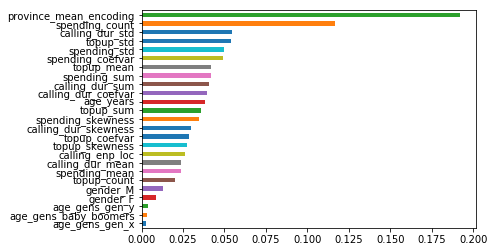

{'DecisionTreeClassifier': {'train_time': 0.0309, 'scores': 0.7142}, 'GaussianNB': {'train_time': 0.0316, 'scores': 0.752}, 'RandomForestClassifier': {'train_time': 1.0856, 'scores': 0.7028}}

{'DecisionTreeClassifier': {'train_time': 0.0298, 'scores': 0.7956}, 'GaussianNB': {'train_time': 0.0265, 'scores': 0.7784}, 'RandomForestClassifier': {'train_time': 1.1961, 'scores': 0.7934}}

{'DecisionTreeClassifier': {'train_time': 0.0292, 'scores': 0.7612}, 'GaussianNB': {'train_time': 0.0256, 'scores': 0.7916}, 'RandomForestClassifier': {'train_time': 1.197, 'scores': 0.7951}}

{'DecisionTreeClassifier': {'train_time': 0.0313, 'scores': 0.7672}, 'GaussianNB': {'train_time': 0.0264, 'scores': 0.7908}, 'RandomForestClassifier': {'train_time': 1.1944, 'scores': 0.7943}}


In [16]:
# https://explained.ai/rf-importance/index.html
# https://medium.com/@srnghn/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3



# fitting random forest to extracting feature important
# feature important is very sensitive to hyperparameter 
# ex. min_samples_leaf=1 -> top1 is "age_years", changing to 10 -> top1 is "province_mean_encoding"
rf = RandomForestClassifier(
         n_estimators=200,
         min_samples_leaf=10,
         n_jobs=-1,
         oob_score=True)

rf.fit(X_train_onehot,y_train)


# feature impoertant chart
feat_importances = pd.Series(rf.feature_importances_, index=X_train_onehot.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.show()


# feature selection 

rf_imp = ['province_mean_encoding'] # select top1

results = {}
for clf in clf_models:
    clf_name = clf.__class__.__name__
    results[clf_name] = cross_val(clf,X_train_onehot[rf_imp], y_train)
    
print(results)


rf_imp = ['province_mean_encoding','spending_count'] # select top2

results = {}
for clf in clf_models:
    clf_name = clf.__class__.__name__
    results[clf_name] = cross_val(clf,X_train_onehot[rf_imp], y_train)

print('')
print(results)

rf_imp = ['province_mean_encoding','spending_count','spending_std'] # select top3

results = {}
for clf in clf_models:
    clf_name = clf.__class__.__name__
    results[clf_name] = cross_val(clf,X_train_onehot[rf_imp], y_train)

print('')
print(results)

rf_imp = ['province_mean_encoding','spending_count','spending_std','topup_std'] # select top4

results = {}
for clf in clf_models:
    clf_name = clf.__class__.__name__
    results[clf_name] = cross_val(clf,X_train_onehot[rf_imp], y_train)

print('')
print(results)

In [46]:
dum = cdr_df.groupby(['callednum','callingnum'])['duration'].sum().reset_index()

In [50]:
def create_key(row):
    row = np.sort(row[:2])
    return str(int(row[0])) + str(int(row[1]))

dum['keys'] = dum.apply(lambda row : create_key(row),axis=1)